In [14]:
import requests
import pandas as pd
from sodapy import Socrata
from arcgis.features import FeatureLayer

# Load in states separately

## Florida
### Please find more information [here](https://open-fdoh.hub.arcgis.com/datasets/florida-covid19-cases-by-county/data?geometry=-105.479%2C23.602%2C-61.226%2C36.843&page=2).

In [2]:
# Load in data from Florida's API
# Helpful link for querying from ArcGis Hub: https://hub.arcgis.com/pages/a0db1c6905934fb5a522137f0fec6c7b
lyr_url = 'https://services1.arcgis.com/CY1LXxl9zlJeBuRZ/arcgis/rest/services/Florida_COVID19_Cases/FeatureServer/0/'
layer = FeatureLayer(lyr_url)
all_features = layer.query()
df_fl = all_features.sdf.filter(items = ['COUNTY', 'COUNTYNAME', 'C_HospYes_Res', 'C_HospYes_NonRes', 'CasesAll'])

In [3]:
# Clean up dataframe
df_fl = df_fl[(df_fl.COUNTYNAME != 'A State') & (df_fl.COUNTYNAME != 'Unknown')]
df_fl['COUNTY'] = '12' + df_fl['COUNTY']
df_fl['COUNTYNAME'] = df_fl['COUNTYNAME'].str.title()
df_fl['Hospitalizations'] = df_fl['C_HospYes_Res'] + df_fl['C_HospYes_NonRes']
df_fl = df_fl.filter(items = ['COUNTY', 'COUNTYNAME', 'Hospitalizations', 'CasesAll'])
df_fl.columns = ['FIPS', 'County', 'Hospitalizations', 'Cases']
df_fl = df_fl.replace('12025','12086')
df_fl.head()

,FIPS,County,Hospitalizations,Cases
0,12041,Gilchrist,80,1588
1,12107,Putnam,566,6374
2,12123,Taylor,97,2710
3,12091,Okaloosa,729,20298
4,12013,Calhoun,59,1686


## Georgia
### Please find more information [here](https://cobb-county-covid-19-hub-cobbcountyga.hub.arcgis.com/datasets/d817e06e4b264905a075b9332cd41962_0/data?page=38&showData=true).

In [4]:
# Load in data from Georgias's API
lyr_url = 'https://services7.arcgis.com/Za9Nk6CPIPbvR1t7/arcgis/rest/services/Georgia_PUI_Data_Download/FeatureServer/0/'
layer = FeatureLayer(lyr_url)
all_features = layer.query()
df_ga = all_features.sdf.sort_values(by=['DATESTAMP'], ascending=False).iloc[:162].filter(items = ['COUNTY', 'H_Cum', 'C_Cum'])

In [5]:
# Clean up dataframe
df_ga['COUNTY'] = df_ga['COUNTY'].str.title()
fips_ga = pd.read_csv("../external_data/ga_fips.csv", dtype={'FIPS': "string"})
df_ga = df_ga.merge(fips_ga, left_on='COUNTY', right_on='Name')
df_ga = df_ga.filter(items = ['FIPS', 'COUNTY', 'H_Cum', 'C_Cum'])
df_ga.FIPS = df_ga.FIPS.astype('object')
df_ga.columns = ['FIPS', 'County', 'Hospitalizations', 'Cases']
df_ga.head()

,FIPS,County,Hospitalizations,Cases
0,13189,Mcduffie,158,1663
1,13105,Elbert,128,1524
2,13201,Miller,40,675
3,13175,Laurens,350,3702
4,13071,Colquitt,247,3511


## Tennessee
### Please find more information [here](https://hub.arcgis.com/datasets/myUTK::tn-cases-by-county/geoservice).

In [6]:
# Load in data from Tennessee's API
lyr_url = 'https://services1.arcgis.com/HLC8bAygObK4fhPW/arcgis/rest/services/TN_Confirmed_Cases_by_County/FeatureServer/0/'
layer = FeatureLayer(lyr_url)
all_features = layer.query()
df_tn = all_features.sdf.filter(items = ['GEOID', 'NAMELSAD', 'HOSPITALIZED_TOT', 'CASES_TOT'])

In [7]:
# Clean up dataframe
df_tn.columns = ['FIPS', 'County', 'Hospitalizations', 'Cases']
df_tn.head()

,FIPS,County,Hospitalizations,Cases
0,47065,Hamilton,1157,43639
1,47115,Marion,112,3110
2,47185,White,110,3570
3,47129,Morgan,44,2471
4,47013,Campbell,126,4114


## Virginia
### Please find more information [here](https://data.virginia.gov/Government/VDH-COVID-19-PublicUseDataset-Cases/bre9-aqqr).

In [8]:
# Load in data from Virginia's API
client = Socrata("data.virginia.gov", None)

results = client.get("bre9-aqqr", limit=133)

df_va = pd.DataFrame.from_records(results, 
                     columns = ['fips', 'locality', 
                                'hospitalizations', 'total_cases'])

In [9]:
# Clean up dataframe
df_va.columns = ['FIPS', 'County', 'Hospitalizations', 'Cases']
df_va.Hospitalizations = df_va.Hospitalizations.astype('int64')
df_va.head()

,FIPS,County,Hospitalizations,Cases
0,51001,Accomack,203,2789
1,51003,Albemarle,213,5666
2,51005,Alleghany,58,1312
3,51007,Amelia,49,870
4,51009,Amherst,120,2886


## Wisconsin
### Please find more information [here](https://hub.arcgis.com/datasets/wi-dhs::covid-19-data-by-county/geoservice).

In [10]:
# Load in data from Wisconsin's API
lyr_url = 'https://dhsgis.wi.gov/server/rest/services/DHS_COVID19/COVID19_WI/MapServer/1/'
layer = FeatureLayer(lyr_url)
all_features = layer.query()
df_wi = all_features.sdf.filter(items = ['GEOID', 'NAME', 'HOSP_YES', 'POSITIVE'])

In [11]:
# Clean up dataframe
df_wi.columns = ['FIPS', 'County', 'Hospitalizations', 'Cases']
df_wi.head()

,FIPS,County,Hospitalizations,Cases
0,55037,Florence,30,442
1,55051,Iron,42,572
2,55091,Pepin,35,841
3,55078,Menominee,60,792
4,55041,Forest,54,949


# Merge into final dataset

In [12]:
df = pd.concat([df_fl, df_ga, df_tn, df_va, df_wi], ignore_index=True)
df = df.drop(df.columns[1], axis=1)
df.Cases = df.Cases.astype('int64')
df.head()

,FIPS,Hospitalizations,Cases
0,12041,80,1588
1,12107,566,6374
2,12123,97,2710
3,12091,729,20298
4,12013,59,1686


In [13]:
# Read in data 
data = pd.read_csv('../data/merged_data.csv', dtype={'FIPS': object})
data = data.drop([data.columns[0],"Deaths", "countycode", "covid_deaths"], axis=1)
data.head()

,FIPS,State,County,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,% Smokers,Food Environment Index,...,% Veterans in Civilian Adult Population,opioid death rate,% Below Poverty,Median Household Income,% No College Degree,Unemployment Rate,% Not in Labor Force,% Jobs in Leisure and Hospitality,% Part-time,% Self-Employed
0,01001,Alabama,Autauga,8128.59119,20.882987,4.743889,4.654031,8.619529,18.081557,7.2,...,12.283,8.992644,12.1,58233.0,16.107796,2.7,40.454576,14.216260,39.604710,7.283256
1,01003,Alabama,Baldwin,7354.12253,17.509134,4.224519,4.304056,8.345003,17.489033,8.0,...,11.938,6.421370,10.1,59871.0,21.044656,2.7,43.511495,20.823355,40.364194,12.669969
2,01005,Alabama,Barbour,10253.57340,29.591802,5.430279,5.185594,11.474559,21.999985,5.6,...,7.672,20.095655,27.1,35972.0,7.609664,3.8,58.630549,9.248695,54.696722,9.675502
3,01007,Alabama,Bibb,11977.53948,19.439724,4.591482,4.551699,10.308710,19.114200,7.8,...,7.152,22.321429,20.3,47918.0,6.451014,3.1,53.033744,4.345937,52.112959,7.547395
4,01009,Alabama,Blount,11335.07113,21.745293,4.860808,4.891455,7.604563,19.208672,8.4,...,8.532,8.644537,16.3,52902.0,8.625066,2.7,44.821051,10.342057,47.550659,7.815851


In [15]:
# Dataset with Hospitalizations
df = df.merge(data, on='FIPS')
df.head()

,FIPS,Hospitalizations,Cases,State,County,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,...,% Veterans in Civilian Adult Population,opioid death rate,% Below Poverty,Median Household Income,% No College Degree,Unemployment Rate,% Not in Labor Force,% Jobs in Leisure and Hospitality,% Part-time,% Self-Employed
0,12041,80,1588,Florida,Gilchrist,8968.375038,21.126757,4.763684,4.847069,7.669173,...,10.311,27.388256,15.0,46171.0,9.381368,3.4,52.053416,7.608085,52.605415,13.496566
1,12107,566,6374,Florida,Putnam,12710.036010,24.952601,5.359802,4.937745,10.439560,...,12.678,13.483813,22.4,41986.0,7.827534,4.3,55.123245,10.481016,52.040792,10.449204
2,12123,97,2710,Florida,Taylor,10593.946360,23.831961,4.855759,4.745002,9.772588,...,7.681,23.123526,19.9,42987.0,5.633540,3.6,54.561016,9.412498,60.553383,6.022409
3,12091,729,20298,Florida,Okaloosa,8033.687940,15.266246,3.889858,3.875538,7.872828,...,22.706,21.710917,10.6,63520.0,19.608361,2.7,40.581558,17.700785,39.062417,11.659616
4,12013,59,1686,Florida,Calhoun,10649.098250,24.278851,4.887984,4.772105,8.024691,...,9.040,34.277096,20.3,41399.0,7.022045,4.1,58.913803,8.432470,56.585692,11.858775


In [16]:
df["Hospitalization Rate"] = round((df.Hospitalizations/df.Population) * 100000, 1)
df["Case Rate"] = round((df.Cases/df.Population) * 100000, 1)
df.head()

,FIPS,Hospitalizations,Cases,State,County,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,...,% Below Poverty,Median Household Income,% No College Degree,Unemployment Rate,% Not in Labor Force,% Jobs in Leisure and Hospitality,% Part-time,% Self-Employed,Hospitalization Rate,Case Rate
0,12041,80,1588,Florida,Gilchrist,8968.375038,21.126757,4.763684,4.847069,7.669173,...,15.0,46171.0,9.381368,3.4,52.053416,7.608085,52.605415,13.496566,438.2,8698.5
1,12107,566,6374,Florida,Putnam,12710.036010,24.952601,5.359802,4.937745,10.439560,...,22.4,41986.0,7.827534,4.3,55.123245,10.481016,52.040792,10.449204,763.2,8594.6
2,12123,97,2710,Florida,Taylor,10593.946360,23.831961,4.855759,4.745002,9.772588,...,19.9,42987.0,5.633540,3.6,54.561016,9.412498,60.553383,6.022409,448.6,12533.0
3,12091,729,20298,Florida,Okaloosa,8033.687940,15.266246,3.889858,3.875538,7.872828,...,10.6,63520.0,19.608361,2.7,40.581558,17.700785,39.062417,11.659616,351.7,9793.1
4,12013,59,1686,Florida,Calhoun,10649.098250,24.278851,4.887984,4.772105,8.024691,...,20.3,41399.0,7.022045,4.1,58.913803,8.432470,56.585692,11.858775,404.5,11558.2


array([[<AxesSubplot:title={'center':'Hospitalization Rate'}>]],
      dtype=object)

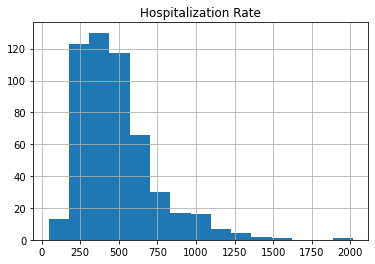

In [17]:
df.hist(column="Hospitalization Rate", bins=15)

In [18]:
# Change to a dummy variable
df["Presence of Water Violation (dummy Y/N)"] = pd.get_dummies(df["Presence of Water Violation"])["Yes"]

# Remove ":1"
df["Other Primary Care Provider Ratio (:1)"] = df["Other Primary Care Provider Ratio"].str.split(":").apply(lambda x: x[0])

In [19]:
# Drop original columns
df = df.drop("Presence of Water Violation", axis=1)
df = df.drop("Other Primary Care Provider Ratio", axis=1)

In [20]:
df["FIPS"].count()

527

In [21]:
df.to_csv('../data/hospitalization_data.csv', index=False)

In [22]:
# Count of counties per state
df.groupby('State').count()["FIPS"]

State
Florida       67
Georgia      159
Tennessee     96
Virginia     133
Wisconsin     72
Name: FIPS, dtype: int64

## The following states have data on Current Hospitalizations instead of Cumulative Hospitalizations, and therefore, will not be used in the dataset at this time.

## California
### Please find more information [here](https://data.ca.gov/dataset/covid-19-hospital-data/resource/42d33765-20fd-44b8-a978-b083b7542225).

In [230]:
# https://stackoverflow.com/questions/45418664/load-ckan-dataset
params = params={
    'resource_id': '42d33765-20fd-44b8-a978-b083b7542225',
    'sort': 'todays_date desc',
    'limit': 56,
}

url = 'https://data.ca.gov/api/3/action/datastore_search'
r = requests.get(url, params=params).json()

df_ca = pd.DataFrame(r['result']['records'], 
                     columns = ['county'
                                , 'hospitalized_covid_patients'])

In [231]:
df_ca.head()

,county,hospitalized_covid_patients
0,Trinity,0.0
1,Glenn,5.0
2,Marin,31.0
3,Los Angeles,4775.0
4,Fresno,507.0


In [232]:
df_ca['hospitalized_covid_patients'].sum()

14578.0

In [326]:
df_ca['county'].nunique()

56

## Connecticut
### Please find more information [here](https://data.ct.gov/Health-and-Human-Services/COVID-19-Cases-Hospitalizations-and-Deaths-By-Coun/bfnu-rgqt).

In [243]:
client = Socrata("data.ct.gov", None)

results = client.get("bfnu-rgqt", limit=8)

df_ct = pd.DataFrame.from_records(results, 
                     columns = ['county'
                                , 'hospitalization'])

In [244]:
df_ct.head()

,county,hospitalization
0,Fairfield,307
1,Hartford,377
2,Litchfield,29
3,Middlesex,41
4,New Haven,397


In [245]:
df_ct['county'].nunique()

8

In [246]:
# matches COVID tracking
pd.to_numeric(df_ct['hospitalization']).sum()

1243

## Pennsylvania
### Please find more information [here](https://data.pa.gov/Health/COVID-19-Aggregate-Hospitalizations-Current-Daily-/kayn-sjhx).

In [140]:
client = Socrata("data.pa.gov", None)

results = client.get("kayn-sjhx", order = 'date desc', limit=81)

df_pa = pd.DataFrame.from_records(results, 
                     columns = ['county'
                                , 'covid_patients'])

In [143]:
df_pa = df_pa[(df_pa.county=='Adams')|
(df_pa.county=='Allegheny')|
(df_pa.county=='Armstrong')|
(df_pa.county=='Beaver')|
(df_pa.county=='Bedford')|
(df_pa.county=='Berks')|
(df_pa.county=='Blair')|
(df_pa.county=='Bradford')|
(df_pa.county=='Bucks')|
(df_pa.county=='Butler')|
(df_pa.county=='Cambria')|
(df_pa.county=='Cameron')|
(df_pa.county=='Carbon')|
(df_pa.county=='Centre')|
(df_pa.county=='Chester')|
(df_pa.county=='Clarion')|
(df_pa.county=='Clearfield')|
(df_pa.county=='Clinton')|
(df_pa.county=='Columbia')|
(df_pa.county=='Crawford')|
(df_pa.county=='Cumberland')|
(df_pa.county=='Dauphin')|
(df_pa.county=='Delaware')|
(df_pa.county=='Elk')|
(df_pa.county=='Erie')|
(df_pa.county=='Fayette')|
(df_pa.county=='Forest')|
(df_pa.county=='Franklin')|
(df_pa.county=='Fulton')|
(df_pa.county=='Greene')|
(df_pa.county=='Huntingdon')|
(df_pa.county=='Indiana')|
(df_pa.county=='Jefferson')|
(df_pa.county=='Juniata')|
(df_pa.county=='Lackawanna')|
(df_pa.county=='Lancaster')|
(df_pa.county=='Lawrence')|
(df_pa.county=='Lebanon')|
(df_pa.county=='Lehigh')|
(df_pa.county=='Luzerne')|
(df_pa.county=='Lycoming')|
(df_pa.county=='McKean')|
(df_pa.county=='Mercer')|
(df_pa.county=='Mifflin')|
(df_pa.county=='Monroe')|
(df_pa.county=='Montgomery')|
(df_pa.county=='Montour')|
(df_pa.county=='Northampton')|
(df_pa.county=='Northumberland')|
(df_pa.county=='Perry')|
(df_pa.county=='Philadelphia')|
(df_pa.county=='Pike')|
(df_pa.county=='Potter')|
(df_pa.county=='Schuylkill')|
(df_pa.county=='Snyder')|
(df_pa.county=='Somerset')|
(df_pa.county=='Sullivan')|
(df_pa.county=='Susquehanna')|
(df_pa.county=='Tioga')|
(df_pa.county=='Union')|
(df_pa.county=='Venango')|
(df_pa.county=='Warren')|
(df_pa.county=='Washington')|
(df_pa.county=='Wayne')|
(df_pa.county=='Westmoreland')|
(df_pa.county=='Wyoming')|
(df_pa.county=='York')]

In [144]:
df_pa.head()

,county,covid_patients
0,Cameron,NaN
1,Cumberland,145.0
2,Lawrence,31.0
3,Luzerne,126.0
4,Tioga,9.0


In [145]:
df_pa['county'].nunique()

67